## Object detection model performance ##

In [22]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import time
import glob
import random
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.fileutils import FileOP

print(f'Project module version: {dm.__version__}')
print(f'Detectron2 version:     {detectron2.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.post1.dev163+g9fa083d.d20240224
Detectron2 version:     0.6


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [25]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
output_dir_predictions = os.path.join(output_dir, 'predictions')
Path(output_dir_predictions).mkdir(parents=True, exist_ok=True)

# Data frame with data splits 
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

# Annotation file for testdata
test_annotation_file_name = 'dentex_detection_test.json'
test_annotation_file = os.path.join(data_dir, test_annotation_file_name)

### Register the test dataset ####

In [4]:
with open(test_annotation_file, 'r') as fl:
    annotations = json.load(fl)
dataset_name = 'dentex_test'
annotations_dict = {dataset_name: annotations}
if dataset_name not in DatasetCatalog:
    DatasetCatalog.register(name=dataset_name, func=lambda d=dataset_name: annotations_dict.get(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

### Detectron2 performance testing ###

In [5]:
# Let's see if we have a saved checkpoint. If not, use this one:
link = 'https://dsets.s3.amazonaws.com/dentex/toothdetection_3K.pth'

# The previous training notebook should have the defined model name
model_name = 'Toothdetector'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir, 
                              model_name,
                              f'version_{model_version}')

last_checkpoint_name = 'model_final.pth'
last_checkpoint = glob.glob(os.path.join(checkpoint_dir, last_checkpoint_name))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "{last_checkpoint_name}" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "{last_checkpoint_name}" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "model_final.pth" in /app/data/model/Toothdetector/version_1.


In [8]:
output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')

# Load the config file. This was created right before training the model.
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(output_dir, model_config_file_name)

# Recreate the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_config_file)
cfg.MODEL.DEVICE = device.type
cfg.MODEL.WEIGHTS = checkpoint_file

# Create the dentex predictor instance
predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, 'dentex_test')

# Create COCO-Evaluator for the test set
evaluator = COCOEvaluator(dataset_name='dentex_test', 
                          tasks=('bbox', ), 
                          distributed=False, 
                          output_dir=output_dir)

# Run model evaluation on test set
results = inference_on_dataset(predictor.model, val_loader, evaluator)
results_df = pd.DataFrame(results.get('bbox'), index=[0]).\
                assign(checkpoint=os.path.basename(checkpoint_file))
print()
display(results_df)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:

,AP,AP50,AP75,APs,APm,APl,checkpoint
0,52.021671,97.638259,46.686021,NaN,61.056106,52.029252,model_final.pth


### Example predictions on the test images ###

In [15]:
files = pd.read_parquet(data_df_file)
files = files.loc[files['dataset']=='test'].\
                reset_index(drop=True)
display(files.head())

# A little helper function to get the rectangle width and height from the bounding box
# Bounding box outputs are:
# upper_left_corner_x, upper_left_corner_y, lower_right_corner_x, lower_right_corner_y
def rectangle(box):
    """ Create the rectangle paramters needed for matplotlib patches """
    width = box[2] - box[0]
    height = box[3] - box[1]
    anchor = (box[0], box[1])
    return anchor, width, height

def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

,image_id,file_name,image_number,file_path,dataset
0,601,train_298.png,298,/app/data/dentex/dentex_detection/quadrant_enu...,test
1,222,train_365.png,365,/app/data/dentex/dentex_detection/quadrant_enu...,test
2,478,train_595.png,595,/app/data/dentex/dentex_detection/quadrant_enu...,test
3,451,train_517.png,517,/app/data/dentex/dentex_detection/quadrant_enu...,test
4,160,train_467.png,467,/app/data/dentex/dentex_detection/quadrant_enu...,test



File 1 of 50: train_298.png with 41 bounding boxes.

The detection of the 41 teeth took 0.224 seconds.



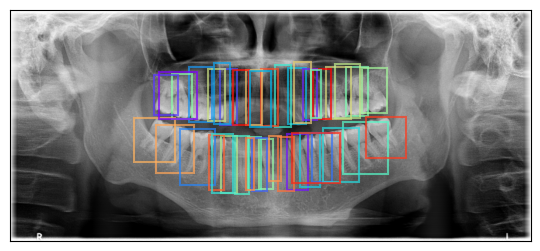


File 2 of 50: train_365.png with 43 bounding boxes.

The detection of the 43 teeth took 0.229 seconds.



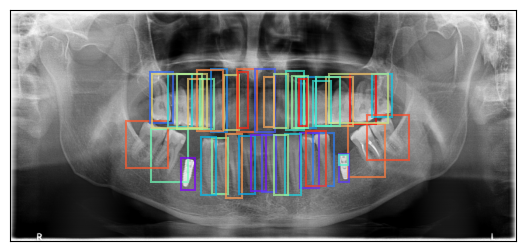


File 3 of 50: train_595.png with 37 bounding boxes.

The detection of the 37 teeth took 0.218 seconds.



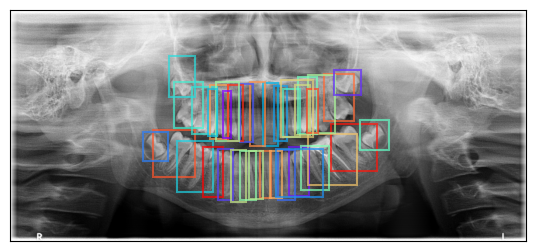


File 4 of 50: train_517.png with 42 bounding boxes.

The detection of the 42 teeth took 0.216 seconds.



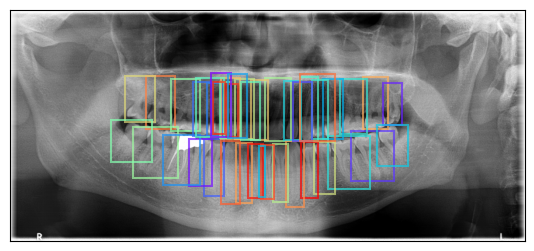


File 5 of 50: train_467.png with 37 bounding boxes.

The detection of the 37 teeth took 0.207 seconds.



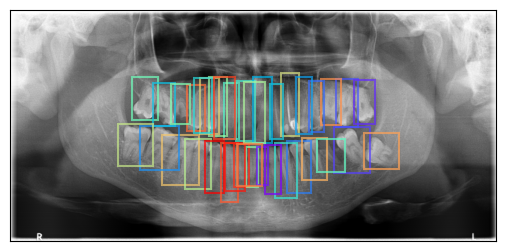


File 6 of 50: train_308.png with 36 bounding boxes.

The detection of the 36 teeth took 0.211 seconds.



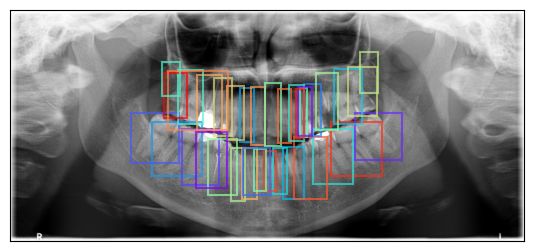


File 7 of 50: train_359.png with 43 bounding boxes.

The detection of the 43 teeth took 0.229 seconds.



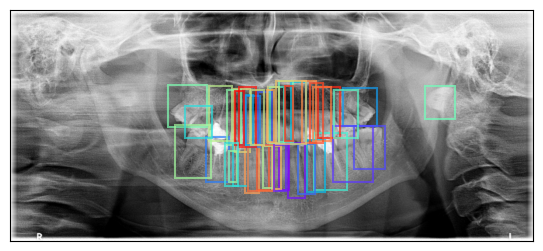


File 8 of 50: train_152.png with 34 bounding boxes.

The detection of the 34 teeth took 0.215 seconds.



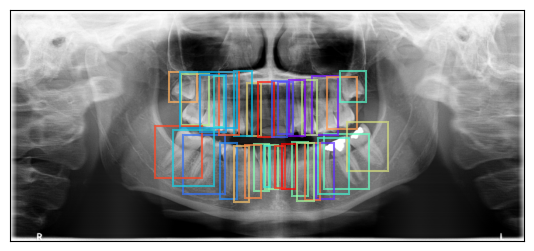


File 9 of 50: train_29.png with 38 bounding boxes.

The detection of the 38 teeth took 0.220 seconds.



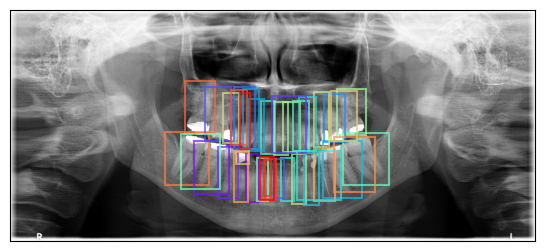


File 10 of 50: train_54.png with 41 bounding boxes.

The detection of the 41 teeth took 0.233 seconds.



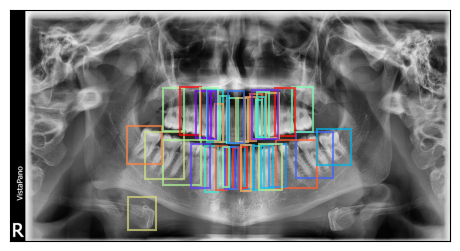


File 11 of 50: train_439.png with 34 bounding boxes.

The detection of the 34 teeth took 0.208 seconds.



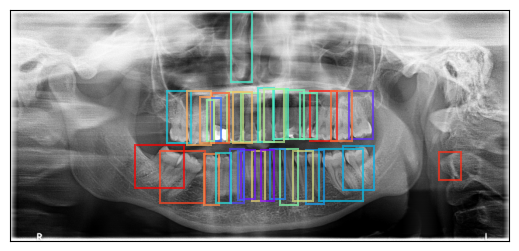


File 12 of 50: train_560.png with 42 bounding boxes.

The detection of the 42 teeth took 0.213 seconds.



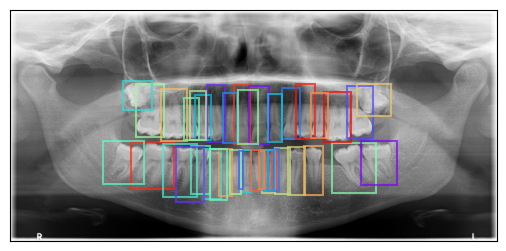


File 13 of 50: train_594.png with 34 bounding boxes.

The detection of the 34 teeth took 0.207 seconds.



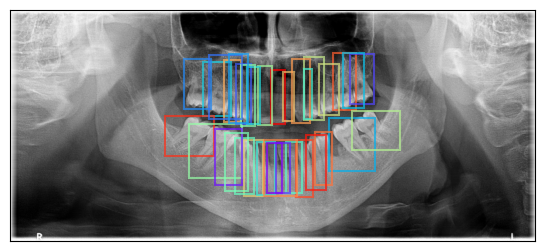


File 14 of 50: train_106.png with 36 bounding boxes.

The detection of the 36 teeth took 0.206 seconds.



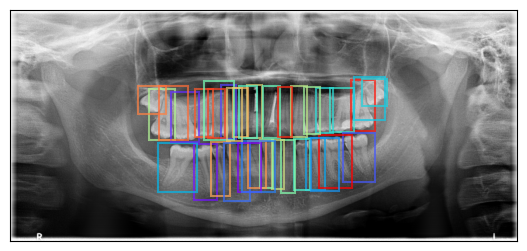


File 15 of 50: train_415.png with 37 bounding boxes.

The detection of the 37 teeth took 0.207 seconds.



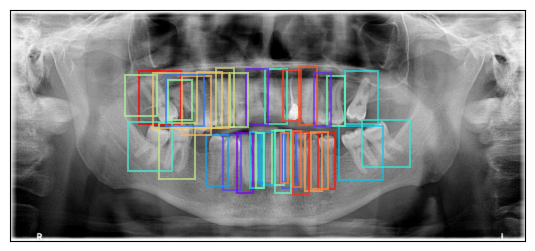

In [27]:
# Load the image
box_df_list = []
n_output_images = 15
for i, image_number in enumerate(files['image_number'].unique()[:n_output_images]):
    start_time = time.time()
    image_df = files.loc[files['image_number'] == image_number]
    image_file = image_df['file_path'].values[0]
    image_name = image_df['file_name'].values[0]
    im = ImageData().load_image(image_file)
    # Predict the bounding boxes for that image (list of tuples)
    pred = predictor(im).get('instances').to('cpu')
    pred_scores = list(pred.scores.numpy())
    pred_boxes = [tuple(np.round(box.numpy()).astype(int)) for box in pred.pred_boxes]
    # Create a list of colors for the rectangles
    color = cm.rainbow(np.linspace(0, 1, len(pred_boxes)))
    color_list = [color[c] for c in range(len(color))]
    random.shuffle(color_list)
    # Draw the image
    fig, ax = show_image(im, figsize=(9, 3))
    # Draw the bounding boxes
    for b, box in enumerate(pred_boxes):
        anchor, width, height = rectangle(box)
        box_dict = {'box_number': [b],
                    'box_score': [pred_scores[b]],
                    'anchor_xy': [anchor],
                    'width': [width],
                    'height': [height]}
        box_df_list.append(image_df.assign(**box_dict))
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=1.5,  
                                 edgecolor=color_list[b],
                                 facecolor='none', 
                                 alpha=0.7)
        ax.add_patch(rect)
    ax.set(xticks=[], yticks=[])
    end_time = time.time()
    dt = (end_time - start_time)
    print()
    print(f'File {i+1} of {len(files)}: {image_name} with {len(pred_boxes)} bounding boxes.')
    print()
    print(f'The detection of the {len(pred_boxes)} teeth took {dt:.3f} seconds.')
    print()
    image_name = f'{os.path.splitext(image_name)[0]}_pred.png'
    plt.savefig(os.path.join(output_dir_predictions, image_name), bbox_inches='tight')
    plt.show()